# Sensors

In [ ]:
import theano

In [1]:
import os
import numpy as np
import pandas as pd
from pass_quality import pass_quality as PQ

ImportError: No module named pass_quality

# Raw data preprocessing in .data_preparing.ipynb

# Load data

In [3]:
def load_data():
    new_pd_data = pd.read_csv('data/new_pd_data_full_int.csv')
    new_pd_data = new_pd_data.drop(['frame_num.1', 'Unnamed: 0', 'ref_pass.1'], axis=1)
    return new_pd_data

In [4]:
new_pd_data = load_data()

In [5]:
data = new_pd_data[new_pd_data['cam_num'] != new_pd_data['cam_num.1']]

# Metrics

# Experiments with features for non-nn classifiers

In [15]:
# 7% better for xgb, and it is really important to use previous values!

# Experiments with classifiers

In [7]:
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [8]:
def fit_clf(clf, pd_data):
    return clf.fit(pd_data.drop(['ref_pass', 'pass', 'pass.1'], axis=1)[-40000:].values, 
                   pd_data['ref_pass'][-40000:].values)

In [22]:
xgb_clf = XGBClassifier(n_estimators=300, objective=PQ)
knn_clf = KNeighborsClassifier(n_neighbors=10)

In [11]:
fit_clf(knn_clf, data)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [12]:
y_true = data['ref_pass'][:-40000].values

In [13]:
y_lab_1 = new_pd_data['pass'][:-40000].values
y_lab_2 = new_pd_data['pass.1'][:-40000].values

In [14]:
y_pred_xgb = xgb_clf.predict(data.drop(['ref_pass', 'pass', 'pass.1'], axis=1)[:-40000].values)

In [15]:
y_pred_knn = knn_clf.predict(data.drop(['ref_pass', 'pass', 'pass.1'], axis=1)[:-40000].values)

In [16]:
print accuracy_score(y_true, y_pred_xgb)
print accuracy_score(y_true, y_pred_knn)

0.781365796121
0.700257046524


In [24]:
print PQ(y_true, y_pred_xgb)

0.264613230662


In [25]:
y_true = new_pd_data['ref_pass'].values
y_lab_1 = new_pd_data['pass'].values
y_lab_2 = new_pd_data['pass.1'].values

# RNN data preparation

In [26]:
from sklearn.preprocessing import LabelBinarizer

In [27]:
#data = new_pd_data

In [28]:
len(data)

129867

In [29]:
#X, y = data.drop(['ref_pass', 'pass', 'pass.1', 'frame_num'], axis=1), data['ref_pass']
X, y = data.drop(['ref_pass'], axis=1), data['ref_pass']
#X, y = data.drop(['ref_pass', 'loop.1', 'frame_num'], axis=1), data['ref_pass']#, 'pass', 'pass.1'], axis=1), data['ref_pass']
#X, y = data.drop(['ref_pass', 'frame_num'], axis=1), data['ref_pass']


In [30]:
X[['loop_sum', 'cor_sum', 'cor.1_sum']] = pd.rolling_sum(X[['loop', 'cor', 'cor.1']], 3)
X = X[2:]

In [31]:
X['frame_num'] = data['frame_num']/np.max(data['frame_num'])

In [32]:
test_size_part = 0.3 #
test_size = np.round(test_size_part*float(len(X))).astype(int)
train_size = len(X) - test_size

In [33]:
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [34]:
bin_y = LabelBinarizer().fit_transform(np.concatenate((y.values, [2])))[:-1].T[:-1].T

In [35]:
bin_y_train, bin_y_test = bin_y[:train_size], bin_y[train_size:]

# Sequence classification with RNN

In [36]:
def prepare_seq_data(X, seq_len=5):
    return np.stack([X.values[seq_len-i:-i] for i in range(1, seq_len+1)], axis=1)
    #return np.stack([X.values[i:-(seq_len-i)] for i in range(seq_len)], axis=1)

In [37]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

In [38]:
#!!!
seq_len = 4

# RNN model architecture

In [83]:
model.predict(prepare_seq_data(X_test, seq_len))

array([[ 0.0447709 ,  0.95519924],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       ..., 
       [ 0.        ,  1.        ],
       [ 0.23930617,  0.76064777],
       [ 0.50653154,  0.49334812]])

In [72]:
model = Sequential()
model.add(LSTM(input_dim=14, output_dim=8, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('hard_sigmoid'))

In [74]:
model.compile(optimizer='rmsprop', loss='mse')

In [81]:
model.fit(prepare_seq_data(X_train, seq_len), 
          bin_y_train[:-seq_len], 
          batch_size=50, 
          nb_epoch=5, 
          shuffle=False)

Epoch 1/5
90901/90901 [==============================] - 12s - loss: 0.1270    
Epoch 2/5
90901/90901 [==============================] - 12s - loss: 0.1259    
Epoch 3/5
90901/90901 [==============================] - 12s - loss: 0.1243    
Epoch 4/5
90901/90901 [==============================] - 12s - loss: 0.1240    
Epoch 5/5
90901/90901 [==============================] - 11s - loss: 0.1231    


In [79]:
accuracy_score(y_test[:-seq_len][:-2], model.predict(prepare_seq_data(X_test, seq_len)).T[1] > 0.5)

0.77577266659821342

In [80]:
PQ(y_test[:-seq_len][:-2].values, model.predict(prepare_seq_data(X_test, seq_len)).T[1] > 0.5)

0.6711921934662707

In [47]:
# model.evaluate(prepare_seq_data(X_test, seq_len), bin_y_test[:-seq_len], batch_size=5)

In [49]:
#accuracy_score(y_train[:-seq_len], (model.predict(prepare_seq_data(X_train, seq_len)).T[1] > 0.5)

In [47]:
accuracy_score(y_train.values[:-seq_len], model.predict(prepare_seq_data(X_train, seq_len)).T[1] > 0.5)

0.80630576121274788

In [48]:
PQ(y_train.values[:-seq_len], model.predict(prepare_seq_data(X_train, seq_len)).T[1] > 0.5)

0.8553948832035595

In [67]:
y_pred_rnn = model.predict(prepare_seq_data(X_train, seq_len)).T[1] > 0.5

In [68]:
 y_pred_rnn_smth = [np.max([y_pred_rnn[i-2],
                           y_pred_rnn[i-1], 
                           y_pred_rnn[i], 
                           y_pred_rnn[i+1],
                           y_pred_rnn[i+2]]) for i in range(2, len(y_pred_rnn)-2)]

In [69]:
y_pred_rnn_smth.append(0)

In [70]:
y_pred_rnn_smth.insert(0, 0)

# Embedding experiments

In [71]:
from sklearn.manifold import Isomap, TSNE
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
%matplotlib inline

In [112]:
isom = Isomap(n_neighbors=5)
pca = PCA(n_components=1)
tsne = TSNE(n_components=2)

In [97]:
X_pca = pd.DataFrame(pca.fit_transform(X.drop(['frame_num'], axis=1), y))

In [152]:
X_tsne = pd.DataFrame(tsne.fit_transform(X[['cor.1']][:1000], y[:1000]))

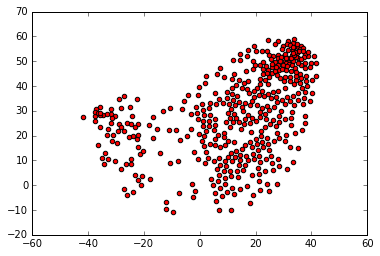

In [153]:
plt.scatter(X_tsne[y == 1].values.T[0], X_tsne[y == 1].values.T[1], c='r')                                 

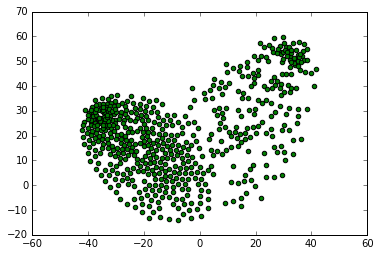

In [154]:
plt.scatter(X_tsne[y == 0].values.T[0], X_tsne[y == 0].values.T[1], c='g')       

# Feature research

In [76]:
pass_quality(data['ref_pass'].values, data['pass.1'].values)

0.935337726523888

In [130]:
xgb_clf = XGBClassifier(n_estimators=300)

#X, y = data[['pass', 'pass.1', 'cor.1', 'cor', 'loop', 'loop.1']], data['ref_pass']

X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [131]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [137]:
xgb_pred = xgb_clf.predict(X_test)

In [141]:
accuracy_score(xgb_pred, y_test[2:])

0.72805441478439425

In [142]:
pass_quality(xgb_pred, y_test.values)

0.8591347872720773